# Sixt Data Science Lab - Test Task for Data Scientist Job Candidates

## Introduction

In this test task you will have an opportunity to demonstrate your skills of a Data Scientist from various angles - processing data, analyzing and vizalizing it, finding insights, applying predictive techniques and explaining your reasoning about it.

The task is based around a bike sharing dataset openly available at UCI Machine Learning Repository [1].

Please go through the steps below, build up the necessary code and comment on your choices.

## Part 1 - Data Loading and Environment Preparation

**Tasks:**
1. Prepare a Python 3 virtual environment (with virtualenv command). requirements.txt output of pip freeze command should be included as part of your submission.
2. Load the data from UCI Repository and put it into the same folder with the notebook. The link to it is https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset . Here is an available mirror in case the above website is down: https://data.world/uci/bike-sharing-dataset
3. We split the data into two parts. One dataset containing the last 30 days and one dataset with the rest.

In [1]:
# I will do the split later by training and testing
# Reason: I don't want to do for that example here data preparation for test and train data twice
# -----------------------------------------------------------------------------------------------

# import pandas as pd
# import numpy as np

# # read raw data
# df_all = pd.read_csv('day.csv')

# # split dataset
# df_last30 = df_all.tail(30)
# df = df_all.iloc[:-30, :]

# df.head()

## Part 2 - Data Processing and Analysis

**Tasks:**
1. Perform all needed steps to load and clean the data. Please comment the major steps of your code.
2. Visualise rentals of bikes per day.
3. Assume that each bike has exactly maximum 12 rentals per day.
    * Find the maximum number of bicycles `nmax` that was needed in any one day.
    * Find the 95%-percentile of bicycles `n95` that was needed in any one day.
5. Visualize the distribution of the covered days depending on the number of available bicycles (e.g. `nmax` bicycles would cover 100% of days, `n95` covers 95%, etc.)


### 2.1. load and clean the bicicle data

main steps will be:
* load data and identify size and types of it and got a first view
* load metadata and adjust types, if necessary
* got smart statistic 
* check for missing and correct, if necessary

In [2]:
import json
import pickle
import shap
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from datetime import datetime
from sklearn.ensemble import RandomForestRegressor
from sklearn.feature_selection import RFECV
from sklearn.metrics import mean_absolute_error, mean_squared_error
from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import TimeSeriesSplit

/mnt/c/Users/Jan/Documents/Python/sixt-coding-challange/.venv/lib/python3.12/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [3]:
# read raw data --> I do it here for the whole dataset (train and test data) to avoid doing it twice
df_bicycle = pd.read_csv("day.csv")
print(f"size of database {df_bicycle.shape}\n")  # show the number of rows and columns
print(df_bicycle.dtypes)  # show the data types of the columns
df_bicycle.head(10)  # show the first 5 rows

size of database (731, 16)

instant         int64
dteday         object
season          int64
yr              int64
mnth            int64
holiday         int64
weekday         int64
workingday      int64
weathersit      int64
temp          float64
atemp         float64
hum           float64
windspeed     float64
casual          int64
registered      int64
cnt             int64
dtype: object


,instant,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
0,1,2011-01-01,1,0,1,0,6,0,2,0.344167,0.363625,0.805833,0.160446,331,654,985
1,2,2011-01-02,1,0,1,0,0,0,2,0.363478,0.353739,0.696087,0.248539,131,670,801
2,3,2011-01-03,1,0,1,0,1,1,1,0.196364,0.189405,0.437273,0.248309,120,1229,1349
3,4,2011-01-04,1,0,1,0,2,1,1,0.200000,0.212122,0.590435,0.160296,108,1454,1562
4,5,2011-01-05,1,0,1,0,3,1,1,0.226957,0.229270,0.436957,0.186900,82,1518,1600
5,6,2011-01-06,1,0,1,0,4,1,1,0.204348,0.233209,0.518261,0.089565,88,1518,1606
6,7,2011-01-07,1,0,1,0,5,1,2,0.196522,0.208839,0.498696,0.168726,148,1362,1510
7,8,2011-01-08,1,0,1,0,6,0,2,0.165000,0.162254,0.535833,0.266804,68,891,959
8,9,2011-01-09,1,0,1,0,0,0,1,0.138333,0.116175,0.434167,0.361950,54,768,822
9,10,2011-01-10,1,0,1,0,1,1,1,0.150833,0.150888,0.482917,0.223267,41,1280,1321


**Answers / comments / reasoning:**
Here I checked rudimentaey the database. By comparison with website https://archive.ics.uci.edu/ml/datasets/bike+sharing+dataset, I identify that 
* some int-variables must be handled for modelling as categories.
* dteday should be handled as date-type   
* instant (is row index) can be deleted or set as index in our database. I prefer deletion.

To change the data-types I created a metatable (given on webside) for our variables (I will attach it also to the feedback files). After reading these metatable I will change some numeric variables to category-variables. Therefore I created a definion, which I want to use later in our modelling code.

In [4]:
# load metadata to DataFrame and define Type of variables correctly
with open("metadata.json", "r") as file:
    metadata = json.load(file)

# converting json dataset from dictionary to dataframe
df_metadata = pd.DataFrame.from_dict(metadata)
df_metadata = df_metadata[df_metadata["Variable"] != "hr"]

# set lists for category and binary features
categorical = df_metadata[df_metadata["Type"] == "Categorical"]["Variable"].tolist()
binary = df_metadata[df_metadata["Type"] == "Binary"]["Variable"].tolist()
datevar = df_metadata[df_metadata["Type"] == "Date"]["Variable"].tolist()

print("metadata of variables:")
df_metadata

metadata of variables:


,Variable,Role,Type,Demographic,Description,Units,Missing Values
0,instant,ID,Integer,,record index,,no
1,dteday,Feature,Date,,date,,no
2,season,Feature,Categorical,,"1:winter, 2:spring, 3:summer, 4:fall",,no
3,yr,Feature,Categorical,,"year (0: 2011, 1: 2012)",,no
4,mnth,Feature,Categorical,,month (1 to 12),,no
6,holiday,Feature,Binary,,weather day is holiday or not (extracted from ...,,no
7,weekday,Feature,Categorical,,day of the week,,no
8,workingday,Feature,Binary,,"if day is neither weekend nor holiday is 1, ot...",,no
9,weathersit,Feature,Categorical,,"- 1: Clear, Few clouds, Partly cloudy, Partly ...",,no
10,temp,Feature,Continuous,,Normalized temperature in Celsius. The values ...,C,no


In [5]:
# change data type of variables
def change_dtype(df, categorical: [], binary: [], datevar: []) -> pd.DataFrame:
    """
    Change the data type of the variables in the dataframe according to the metadata
    Parameters
        df: dataframe
        categorical: list of categorical variables
        binary: list of binary variables
        datevar: list of date variables
    Returns
        dataframe with the correct data types
    """

    if "instant" in df.columns:
        df.drop(["instant"], axis=1, inplace=True)
    for col in df.columns:
        if col in categorical:
            df[col] = df[col].astype("category")
        elif col in binary:
            df[col] = df[col].astype("boolean")
        elif col in datevar:
            df[col] = df[col].astype("datetime64[ns]")
    return df


df_bicycle = change_dtype(df_bicycle, categorical, binary, datevar)

print(df_bicycle.dtypes)  # show the data types of the columns

dteday        datetime64[ns]
season              category
yr                  category
mnth                category
holiday              boolean
weekday             category
workingday           boolean
weathersit          category
temp                 float64
atemp                float64
hum                  float64
windspeed            float64
casual                 int64
registered             int64
cnt                    int64
dtype: object


In [6]:
# show standard statistics of the data
df_bicycle.describe(include="all")

,dteday,season,yr,mnth,holiday,weekday,workingday,weathersit,temp,atemp,hum,windspeed,casual,registered,cnt
count,731,731.0,731.0,731.0,731,731.0,731,731.0,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000,731.000000
unique,NaN,4.0,2.0,12.0,2,7.0,2,3.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
top,NaN,3.0,1.0,1.0,False,0.0,True,1.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
freq,NaN,188.0,366.0,62.0,710,105.0,500,463.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN
mean,2012-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.495385,0.474354,0.627894,0.190486,848.176471,3656.172367,4504.348837
min,2011-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.059130,0.079070,0.000000,0.022392,2.000000,20.000000,22.000000
25%,2011-07-02 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.337083,0.337842,0.520000,0.134950,315.500000,2497.000000,3152.000000
50%,2012-01-01 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.498333,0.486733,0.626667,0.180975,713.000000,3662.000000,4548.000000
75%,2012-07-01 12:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.655417,0.608602,0.730209,0.233214,1096.000000,4776.500000,5956.000000
max,2012-12-31 00:00:00,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.861667,0.840896,0.972500,0.507463,3410.000000,6946.000000,8714.000000


In [7]:
# check for missing values
print("check for missing values:")
print(df_bicycle.isna().sum())  # count missing values in the dataset
print()
print(df_bicycle.isnull().sum())  # count missing values in the dataset

check for missing values:
dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64

dteday        0
season        0
yr            0
mnth          0
holiday       0
weekday       0
workingday    0
weathersit    0
temp          0
atemp         0
hum           0
windspeed     0
casual        0
registered    0
cnt           0
dtype: int64


**Answers / comments / reasoning:**

table seems to be fine because   
* statistics looks plausible
* no missing found --> no imputation / truncation needed

no further cleaning needed!

### 2.2. Visualise rentals of bikes per day

/tmp/ipykernel_4487/4012499024.py:62: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


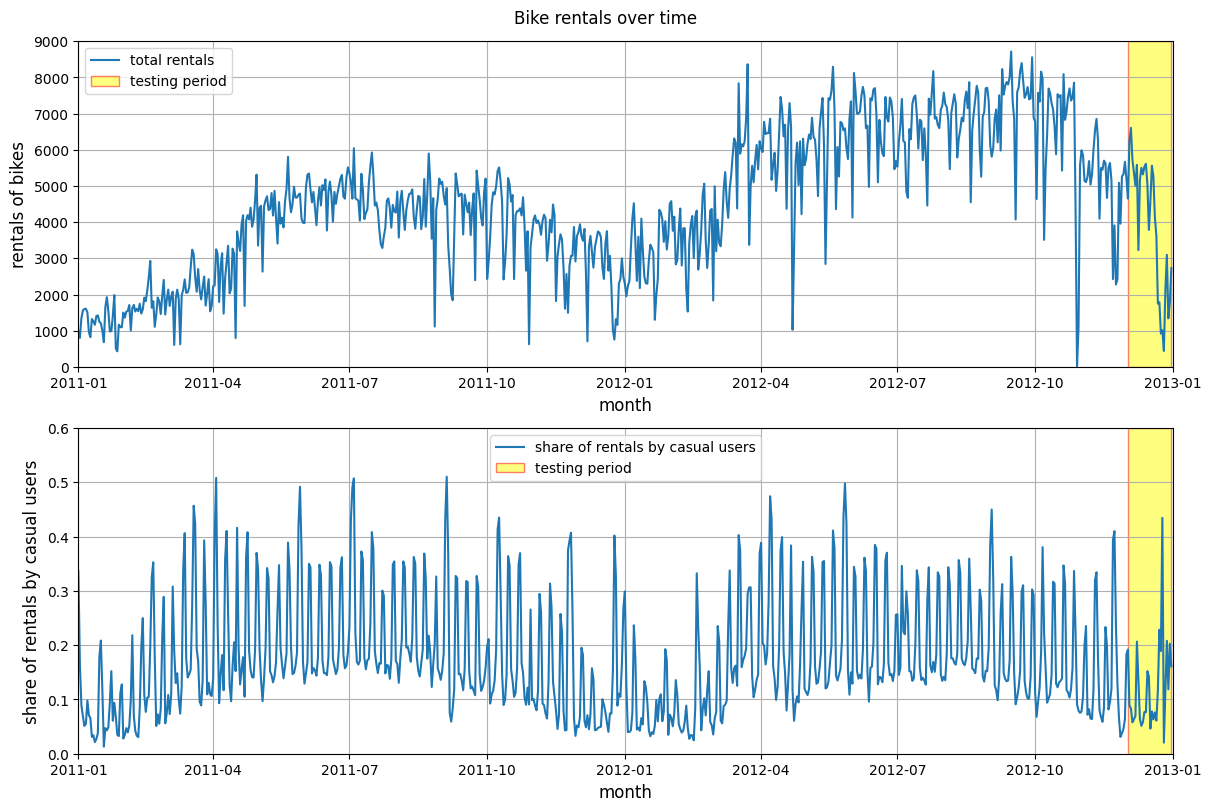

In [8]:
# plot cnt distribution over dteday

# some data preparation for stack plot
time = df_bicycle["dteday"]
casual = df_bicycle["casual"]
registered = df_bicycle["registered"]
share = casual / (casual + registered)
# rental = np.vstack([registered, casual]) # stacked chart does not look fine


# Adjusting the figure size and do two plots
fig, ax = plt.subplots(2, 1, layout="constrained", figsize=(12, 8))

# Creating a plot
ax[0].plot(time, df_bicycle["cnt"], label="total rentals")

# Adding axis labels and customizing their font size
ax[0].set_xlabel("month", fontsize=12)
ax[0].set_ylabel("rentals of bikes", fontsize=12)

# Highlighting the forecasting time period from 02.12.2012 to 31.01.2012 and customizing the shaded area
ax[0].axvspan(
    datetime(2012, 12, 2),
    datetime(2012, 12, 31),
    label="testing period",
    facecolor="yellow",
    alpha=0.5,
    edgecolor="red",
    linewidth=1,
)
ax[0].set_xlim([datetime(2011, 1, 1), datetime(2013, 1, 1)])
ax[0].set_ylim(0, 9000)
ax[0].grid(True)
ax[0].legend()

# -----------------next chart -------------------

# Creating a plot
ax[1].plot(time, share, label="share of rentals by casual users")

# Adding axis labels and customizing their font size
ax[1].set_xlabel("month", fontsize=12)
ax[1].set_ylabel("share of rentals by casual users", fontsize=12)

# Highlighting the forecasting time period from 02.12.2012 to 31.01.2012 and customizing the shaded area
ax[1].axvspan(
    datetime(2012, 12, 2),
    datetime(2012, 12, 31),
    label="testing period",
    facecolor="yellow",
    alpha=0.5,
    edgecolor="red",
    linewidth=1,
)
ax[1].set_xlim([datetime(2011, 1, 1), datetime(2013, 1, 1)])
ax[1].set_ylim(0, 0.6)
ax[1].grid(True)
ax[1].legend()


fig.suptitle("Bike rentals over time")
fig.show()

/tmp/ipykernel_4487/4183355898.py:45: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


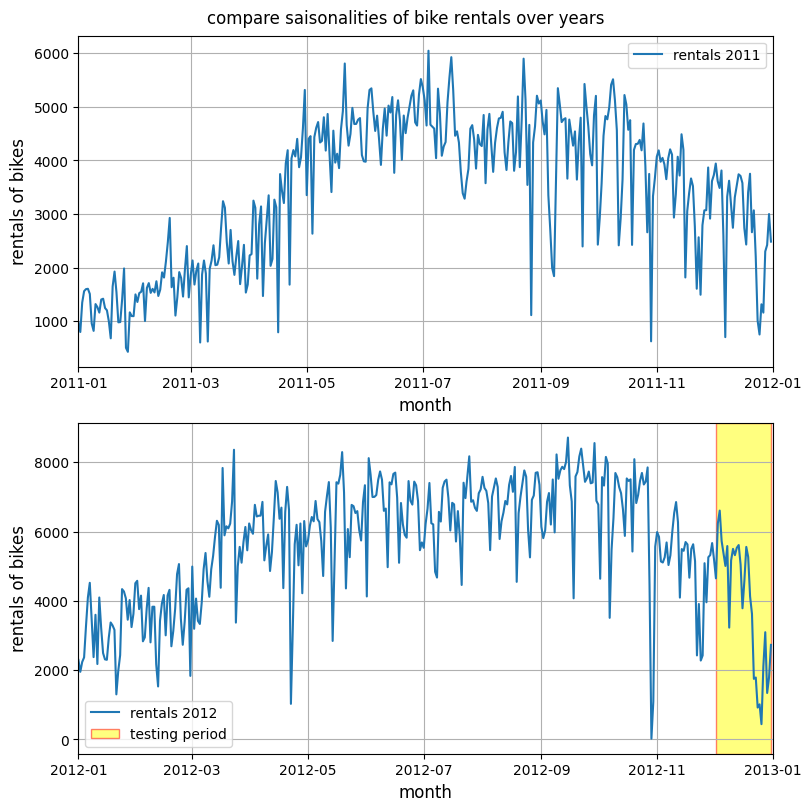

In [9]:
# split dataset by year and plot cnt distribution over months
cnt_bicycle_2011 = df_bicycle[df_bicycle["yr"] == 0]["cnt"]
cnt_bicycle_2012 = df_bicycle[df_bicycle["yr"] == 1]["cnt"]
months_2011 = df_bicycle[df_bicycle["yr"] == 0]["dteday"]
months_2012 = df_bicycle[df_bicycle["yr"] == 1]["dteday"]

# Adjusting the figure size and do two plots
fig, ax = plt.subplots(2, 1, layout="constrained", figsize=(8, 8))

# Creating a plot
ax[0].plot(months_2011, cnt_bicycle_2011, label="rentals 2011")

# Adding axis labels and customizing their font size
ax[0].set_xlabel("month", fontsize=12)
ax[0].set_ylabel("rentals of bikes", fontsize=12)

# Highlighting the forecasting time period from 02.12.2012 to 31.01.2012 and customizing the shaded area
ax[0].set_xlim([datetime(2011, 1, 1), datetime(2012, 1, 1)])
ax[0].grid(True)
ax[0].legend()

# -----------------next chart -------------------

# Creating a plot
ax[1].plot(months_2012, cnt_bicycle_2012, label="rentals 2012")

# Adding axis labels and customizing their font size
ax[1].set_xlabel("month", fontsize=12)
ax[1].set_ylabel("rentals of bikes", fontsize=12)

ax[1].axvspan(
    datetime(2012, 12, 2),
    datetime(2012, 12, 31),
    label="testing period",
    facecolor="yellow",
    alpha=0.5,
    edgecolor="red",
    linewidth=1,
)
ax[1].set_xlim([datetime(2012, 1, 1), datetime(2013, 1, 1)])
ax[1].grid(True)
ax[1].legend()

fig.suptitle("compare saisonalities of bike rentals over years")
fig.show()

**Answers / comments / reasoning:**

plots of bike rentals over years and months show 
* a clear saisonality
* a clear trend over the years
* clear decrease at christmas time

the share of rentals by casual users show
* a clear saisonality
* no clear trend over the years


### 2.3. Assume that each bike has exactly maximum 12 rentals per day.
* Find the maximum number of bicycles `nmax` that was needed in any one day.
* Find the 95%-percentile of bicycles `n95` that was needed in any one day.

In [10]:
df_bicycle["bicycle"] = np.ceil(
    df_bicycle["cnt"] / 12
)  # 12 is the number of max rentals by bike by day
nmax = df_bicycle["bicycle"].max()
n95 = np.floor(
    df_bicycle["bicycle"].quantile(
        0.95,
    )
)
print(f"maximum number of needed bicycles on one day is: {nmax}")
print(f"95%-percentile of needed bicycles on one day is: {n95}")

maximum number of needed bicycles on one day is: 727.0
95%-percentile of needed bicycles on one day is: 631.0


### 2.4. Visualize the distribution of the covered days depending on the number of available bicycles (e.g. `nmax` bicycles would cover 100% of days, `n95` covers 95%, etc.)

statistics of needed bicycles by day:


/tmp/ipykernel_4487/896453415.py:57: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


count    731.000000
mean     375.826265
std      161.444502
min        2.000000
25%      263.000000
50%      379.000000
75%      496.500000
max      727.000000
Name: bicycle, dtype: float64

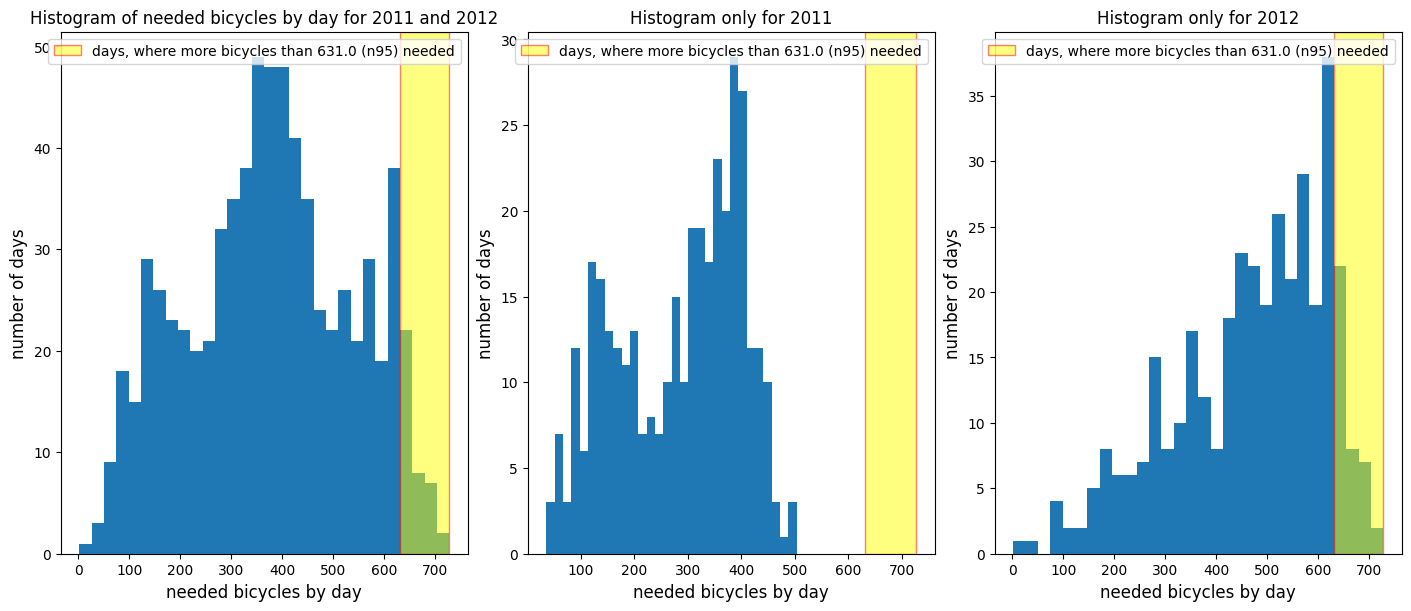

In [11]:
fig, ax = plt.subplots(1, 3, layout="constrained", figsize=(14, 6))

# We can set the number of bins with the *bins* keyword argument.
n_bins = 30
# chart for 2011 and 2012
ax[0].hist(df_bicycle["bicycle"], bins=n_bins)
ax[0].set_xlabel("needed bicycles by day", fontsize=12)
ax[0].set_ylabel("number of days", fontsize=12)
ax[0].set_title("Histogram of needed bicycles by day for 2011 and 2012")

ax[0].axvspan(
    n95,
    nmax,
    label=f"days, where more bicycles than {n95} (n95) needed",
    facecolor="yellow",
    alpha=0.5,
    edgecolor="red",
    linewidth=1,
)
ax[0].legend()

# chart for 2011
ax[1].hist(df_bicycle[df_bicycle["yr"] == 0]["bicycle"], bins=n_bins)
ax[1].set_xlabel("needed bicycles by day", fontsize=12)
ax[1].set_ylabel("number of days", fontsize=12)
ax[1].set_title("Histogram only for 2011")

ax[1].axvspan(
    n95,
    nmax,
    label=f"days, where more bicycles than {n95} (n95) needed",
    facecolor="yellow",
    alpha=0.5,
    edgecolor="red",
    linewidth=1,
)
ax[1].legend()

# chart for 2012
ax[2].hist(df_bicycle[df_bicycle["yr"] == 1]["bicycle"], bins=n_bins)
ax[2].set_xlabel("needed bicycles by day", fontsize=12)
ax[2].set_ylabel("number of days", fontsize=12)
ax[2].set_title("Histogram only for 2012")

ax[2].axvspan(
    n95,
    nmax,
    label=f"days, where more bicycles than {n95} (n95) needed",
    facecolor="yellow",
    alpha=0.5,
    edgecolor="red",
    linewidth=1,
)
ax[2].legend()


fig.show()

print("statistics of needed bicycles by day:")
df_bicycle["bicycle"].describe()

In [12]:
# check in which year more bicycles than n95 are needed
df_bicycle[df_bicycle["bicycle"] > n95].groupby("yr", observed=False)["bicycle"].count()

yr
0     0
1    37
Name: bicycle, dtype: int64

**further Answers / comments / reasoning:**

* only in 2012 are more bicycles needed than 631 (n95)
* distributions of years are very different and not well distributed


## Part 3 - Building prediction models

**Tasks:**
1. Define a test metric for predicting the daily demand for bike sharing, which you would like to use to measure the accuracy of the constructed models, and explain your choice.
2. Build a demand prediction model with Random Forest, preferably making use of following python libraries: scikit-learn. 
3. Report the value of the chosen test metric on the provided data. 

### 3.1. Define a test metric for predicting the daily demand for bike sharing, which you would like to use to measure the accuracy of the constructed models, and explain your choice.

A commonly used test metric for predicting time serious are the Mean Absolute Error (MAE) and the Mean Squared Error (MSE)
* MAE is calculated by taking the average of the absolute differences between the predicted values and the actual values. 
* MSE is calculated by taking the average of the squared differences between the predicted values and the actual values. 
Both meatures provides a balanced view of model performance by considering both overestimation and underestimation errors equally. A metric, where we got an unbalanced estimation is RMSLE (https://scikit-learn.org/stable/modules/model_evaluation.html#mean-squared-log-error). This metric penalize under predictions more than over predictions. 


For this task I prefer a balanced error estimation, where none  of these errors are favored. In addition, I personally prefer the MAE because
* it is easy to interpret: in our case, it represent the average error in the number of predicted to be needed bike demands each day. 
* it is robustness to Outliers: MAE is less sensitive to outliers compared to MSE. Therefore it is suitable for datasets where extreme values might occur occasionally (e.g. by weather). 

Anyway, each data set is different and I will have a look on both metrics in the following but will concentrate on MAE.

### 3.2. Build a demand prediction model with Random Forest, preferably making use of following python libraries: [scikit-learn](https://scikit-learn.org/stable/). 
#### 3.2.1 Data preparation
* quick data overview
* change category variables to binary features
* standardize features if necessary -> is not necessary, because we use a tree-based model
* delete unnecessary features 
* split test and train data

Pairplot of continuous variables



<Figure size 500x900 with 0 Axes>

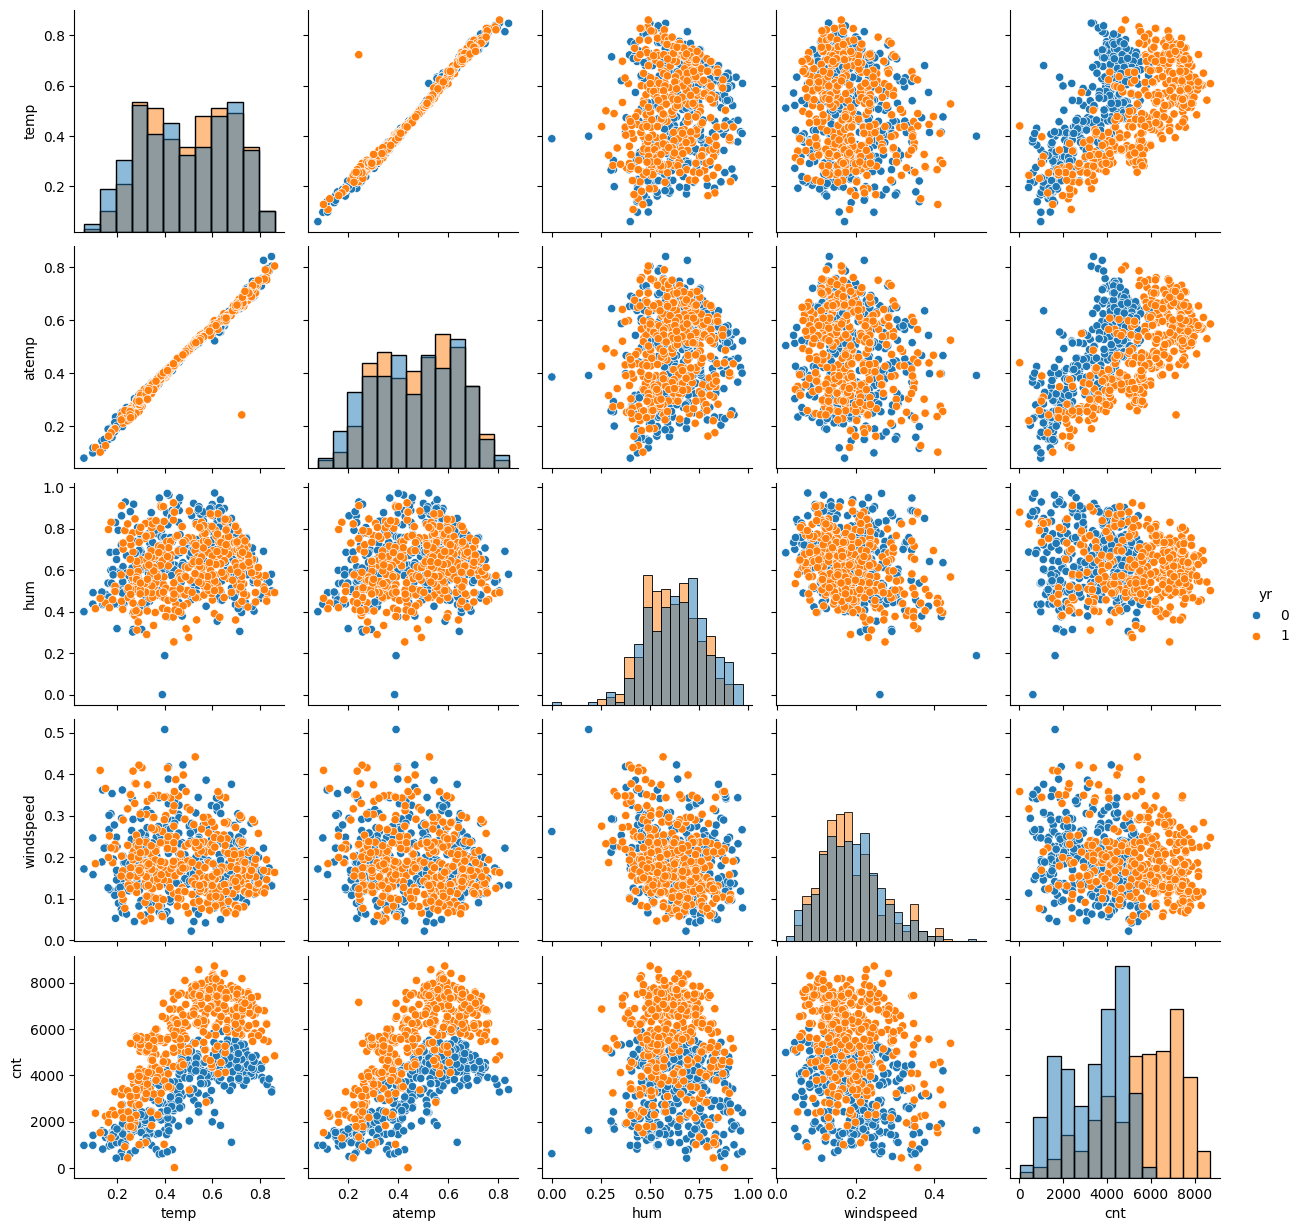

In [13]:
# do some quick data overivew for continuous variables
print("Pairplot of continuous variables\n")
plt.figure(figsize=(5, 9))
sns.pairplot(
    data=df_bicycle.drop(
        ["holiday", "workingday", "casual", "registered", "bicycle"], axis=1
    ),
    hue="yr",
    diag_kind="hist",
)
plt.show()

**comments**

atemp (feeling temperature) and temp (temperature) are highly correlated: --> because of colinearity, I will ignore atemp (feeling temperature)

/tmp/ipykernel_4487/3774406389.py:9: UserWarning: FigureCanvasAgg is non-interactive, and thus cannot be shown
  fig.show()


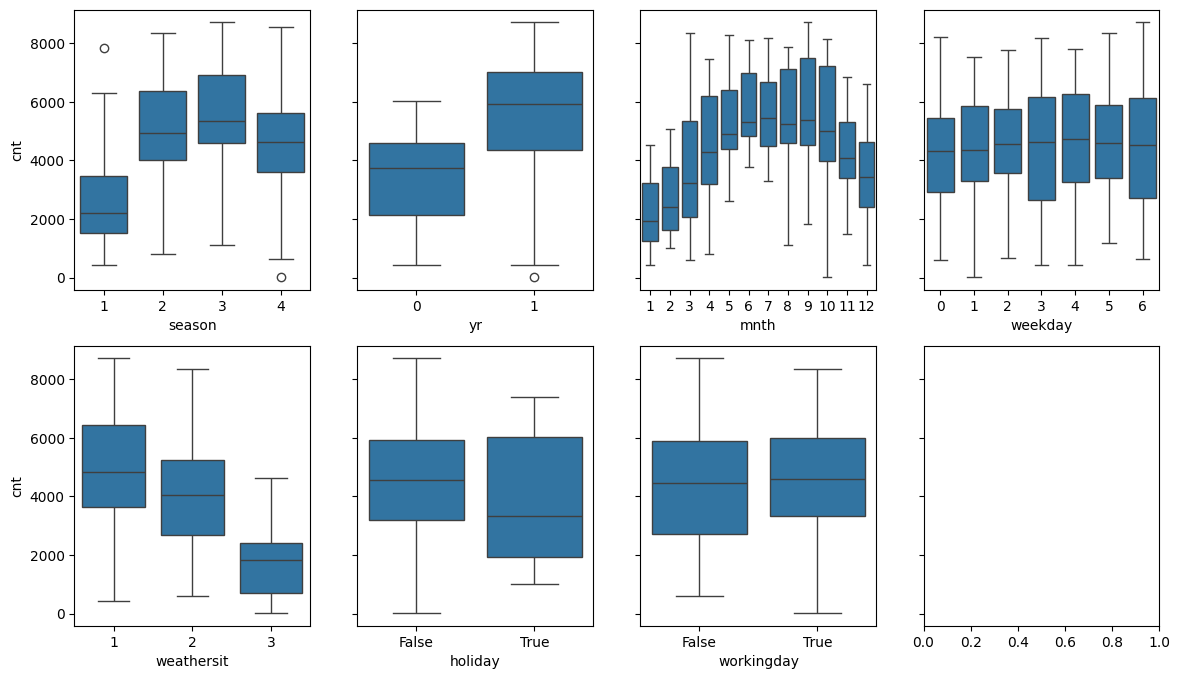

In [14]:
# do some quick box plots for continuous variables
catvar = categorical + binary
fig, axs = plt.subplots(nrows=2, ncols=4, sharey=True, figsize=(14, 8))
for i, col in enumerate(catvar):
    j = 0 if i < 4 else 1
    k = i if i < 4 else i - 4
    sns.boxplot(ax=axs[j, k], data=df_bicycle, x=col, y="cnt")

fig.show()

**comments**

Better to not do one hot encoding for the date feature (month) as for other categorical variables. It is a technically ordinal features (categorical features with an order). By converting them to a one-hot encoded representation you are losing the time order dimension and the trend information.

When one include "Month" as an integer variables in our feature set, we got the problem, that December and January are not next to each other. One feature engineering trick for cyclical features (like month or hour for example) is, to create an additional features by converting with a tigonometric functions sinus and/or cosine. Here I will use the function:
```bash
    X[‘month_cos’] = -np.cos(2*np.pi*X.month/12)
    X[‘month_sin’] = -np.sin(2*np.pi*X.month/12)
``` 
That it is appropriate, can be seen directly within the Boxplot of month aboth, which look like a cosine function. I don't use this cyclical feature encoding for season (to less categories) and not for weekday (cyclic dependency is not clear).

Pros and Cons as well backgrounds: [cyclical-features-encoding](https://towardsdatascience.com/cyclical-features-encoding-its-about-time-ce23581845ca)

***Note:*** I tested both for the model later on, but I finally decide to proceed with this cyclical feature encoding.


In [15]:
# data preparation for the model for the model
# - cyclical feature encoding for month
# - one-hot-encoding for categorical variables
# - delete unnecessary features

df_bicycle["month_cos"] = np.cos(
    2 * np.pi * (df_bicycle["mnth"].astype("int32") - 1) / 12
)  # change the period to 0-11
df_bicycle["month_sin"] = np.sin(
    2 * np.pi * (df_bicycle["mnth"].astype("int32") - 1) / 12
)  # change the period to 0-11
df_bicycle_red = df_bicycle.drop(["mnth"], axis=1)


# change category variables to binary variables
def category_to_binary(df, categorical: []) -> pd.DataFrame:
    """
    Change the category variables to binary variables
    Parameters
        df: dataframe
        categorical: list of categorical variables
    Returns
        dataframe with the binary variables
    """
    for col in categorical:
        if col in df.columns:
            df = pd.concat(
                [df, pd.get_dummies(df[col], prefix=col, drop_first=True)], axis=1
            )  # drop_first = True to avoid multicollinearity
            df.drop(
                [col], axis=1, inplace=True
            )  # drop original variable after encoding
    return df


print(f"transform categorical variables: {categorical}\n")
X = category_to_binary(df_bicycle_red, categorical)

# standardize features -> is not necessary, because we should use a tree-based model

# delete unnecessary features and define independent variables
drop_columns = [
    "dteday",  # we do not need the date for the prediction
    "casual",  # distinguish between casual and registered users is not necessary
    "registered",  # distinguish between casual and registered users is not necessary
    "cnt",  # dependent variable
    "bicycle",  # linear to dependent variable and we do not need it anymore
    "atemp",  # heavily linear dependent to temp
]
X.drop(drop_columns, axis=1, inplace=True)

# define dependent variable
y = df_bicycle_red["cnt"]

print("head of independent variables:")
X.head()

transform categorical variables: ['season', 'yr', 'mnth', 'weekday', 'weathersit']

head of independent variables:


,holiday,workingday,temp,hum,windspeed,month_cos,month_sin,season_2,season_3,season_4,yr_1,weekday_1,weekday_2,weekday_3,weekday_4,weekday_5,weekday_6,weathersit_2,weathersit_3
0,False,False,0.344167,0.805833,0.160446,1.0,0.0,False,False,False,False,False,False,False,False,False,True,True,False
1,False,False,0.363478,0.696087,0.248539,1.0,0.0,False,False,False,False,False,False,False,False,False,False,True,False
2,False,True,0.196364,0.437273,0.248309,1.0,0.0,False,False,False,False,True,False,False,False,False,False,False,False
3,False,True,0.200000,0.590435,0.160296,1.0,0.0,False,False,False,False,False,True,False,False,False,False,False,False
4,False,True,0.226957,0.436957,0.186900,1.0,0.0,False,False,False,False,False,False,True,False,False,False,False,False


#### 3.2.2 Training of the [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) of scikit-learn 

In [16]:
# split test and train data
X_test = X.tail(30)
X_train = X.iloc[:-30, :]
y_test = y.tail(30)
y_train = y.iloc[:-30]

print(f"size of train data: {X_train.shape} and dependent variable: {y_train.shape}")
print(f"size of test data: {X_test.shape} and dependent variable: {y_test.shape}")

size of train data: (701, 19) and dependent variable: (701,)
size of test data: (30, 19) and dependent variable: (30,)


**create some definitions for evaluation** 
- kpis for evaluation kpis
- plot predictions against true values
- plot feature importance

In [17]:
def evaluate_model(y_test, y_test_pred):
    """
    Evaluate the model with some metrics
    Parameters
        y_test: true test values
        y_test_pred: predicted values
    """
    mae = mean_absolute_error(y_test, y_test_pred)
    mse = mean_squared_error(y_test, y_test_pred)
    mape = mae / np.mean(y_test) * 100  # Mean Absolute Percentage Error
    accuracy = 100 - mape
    print("Mean Absolute Error:  ", mae)
    print("Mean Squared Error:   ", mse)
    print("Accuracy:             ", round(accuracy, 2), "%. ")
    print("avg error rate by day:", round(mape, 2), "%. \n")


def plot_predictions_vs_true_values(y_train, y_test, y_test_pred):
    """
    Plot the predictions vs true values
    Parameters
        y_train: train values
        y_test: true test values
        y_test_pred: predicted values
    """

    y_test_pred_series = pd.Series(y_test_pred, index=list(y_test.index.values))

    fig, ax = plt.subplots(nrows=1, ncols=3, sharey=True, figsize=(14, 4))

    for i in range(3):
        y_train.plot(ax=ax[i], label="train")
        y_test.plot(ax=ax[i], label="test")
        y_test_pred_series.plot(ax=ax[i], label="predictions")
        ax[i].legend()

    ax[0].set_xlim(0, 730)
    ax[0].set_title("All data")
    ax[1].set_xlim(365, 730)
    ax[1].set_title("last 365 days")
    ax[2].set_xlim(640, 730)
    ax[2].set_title("last 90 days")


def plot_feature_importances(model, features):
    """
    Plot the feature importances
    Parameters
        model: trained model
        features: list of features
    """

    n_features = len(features)
    importances = model.feature_importances_
    indices = np.argsort(importances)

    fig, ax = plt.subplots()
    ax.barh(range(n_features), importances[indices], align="center")
    ax.set_yticks(range(n_features))
    ax.set_yticklabels(np.array(features)[indices])
    ax.set_xlabel("Feature importance")
    ax.set_ylabel("Feature")


def plot_feature_importances_shap(model, X, max_display=10):
    """
    Plot the feature importances with SHAP
    Parameters
        model: trained model
        X_test: test data
    """
    explainer = shap.Explainer(model)
    shap_values = explainer(X)
    max_display = 10

    # will here only show bar plot and waterfall plot
    shap.plots.bar(shap_values, max_display=15)
    shap.plots.waterfall(shap_values[0], max_display=max_display)
    # shap.summary_plot(shap_values, X, max_display=max_display)
    # shap.plots.heatmap(shap_values, max_display=max_display)

**Create first basic model**

In [18]:
# Starting model training ...

# Initialize Random Forest regressor
rf_regressor = RandomForestRegressor(
    n_estimators=100, random_state=17, n_jobs=-1, min_samples_leaf=0.01
)

# Train the model
rf_regressor = rf_regressor.fit(X_train, y_train)

# Predict the model for test data
y_test_pred = rf_regressor.predict(X_test)
y_train_pred = rf_regressor.predict(X_train)

print(f"model score on training data: {rf_regressor.score(X_train, y_train)}")
print(f"model score on testing data: {rf_regressor.score(X_test, y_test)}")

model score on training data: 0.9054505071700765
model score on testing data: 0.5733980276906623


Evaluate model on training data:
Mean Absolute Error:   417.4421852862399
Mean Squared Error:    355253.45434092963
Accuracy:              90.78 %. 
avg error rate by day: 9.22 %. 

Evaluate model on training data:
Mean Absolute Error:   977.6755108470387
Mean Squared Error:    1365983.5234970304
Accuracy:              75.25 %. 
avg error rate by day: 24.75 %. 



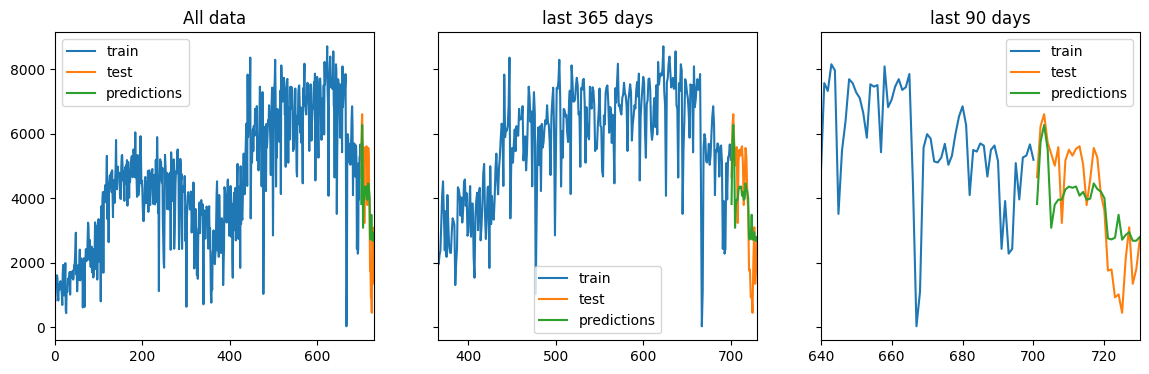

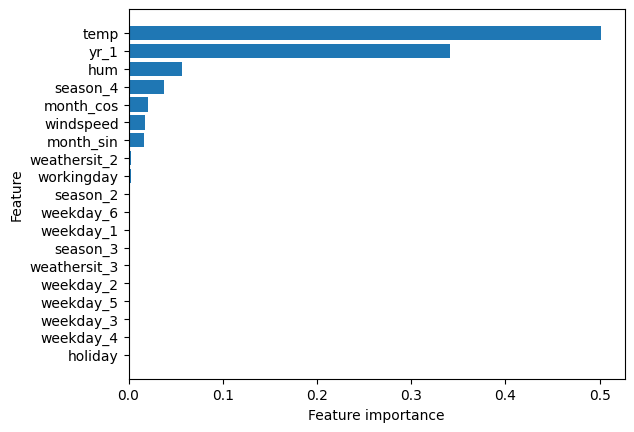

In [19]:
# Evaluate first model
print("Evaluate model on training data:")
evaluate_model(y_train, y_train_pred)

print("Evaluate model on training data:")
evaluate_model(y_test, y_test_pred)

plot_predictions_vs_true_values(y_train, y_test, y_test_pred)

plot_feature_importances(rf_regressor, X_train.columns)

**comments**
This simple model is normally only the first step. But we already see:
* we got an rate of +/-24.8 % by day 
* not all features are relevant (reason: min 1% of our samples have to stay at the end on a leaf)
* detail-trends can not be predicted correctly


#### 3.2.3 Hyperparameter tuning
To get better results, we will do now Hyperparameter tuning. Especially for machine learning models like random forest is it necessarey, because often we will receive better results by changed parameters. Especially for the following hyperparameter, I want to do some grit search:
* n_estimators: The number of trees in the forest.
* criterion: The function to measure the quality of a split. Will test here the default: "absolute_error", "squared_error" and others -> think first one will lead to success because of evaluation metric
* max_depth: The maximum depth of the tree. If None, then nodes are expanded until all leaves are pure or until all leaves contain less than min_samples_split samples. 
* min_samples_leaf: The minimum number of samples in newly created leaves. To avoid weighting outliers I prefer to use here some values between 1% and 10%  
* max_features: The number of features to consider when looking for the best split. I prefer small models for handling - here I wish between 5 and 10.
* bootstrap : Whether bootstrap samples are used when building trees.

Within the  GridSearch, we will not use the standard cross-validation (random split) because it is cheating for time series data, because it is looking at the future by searching the best parameters for the model. Instead I will use the [TimeSeriesSplit](https://scikit-learn.org/stable/modules/generated/sklearn.model_selection.TimeSeriesSplit.html#sklearn.model_selection.TimeSeriesSplit) function of scikit-learn. More details on that topic: [Cross Validation in Time Series](https://medium.com/@soumyachess1496/cross-validation-in-time-series-566ae4981ce4)


In [20]:
# to avoid cheating, I use a time-series based split for cv at the grid search
# (random split is cheating because it is looking at the future by searching the best parameters for the model)

tscv = TimeSeriesSplit(n_splits=5, test_size=30)
rf_regressor = RandomForestRegressor(random_state=17, n_jobs=-1)
parameters = {
    "criterion": ("squared_error", "absolute_error"),
    "n_estimators": [100, 300],
    "bootstrap": [True, False],
    "max_features": [10, None],
    "max_depth": [10, None],
    "min_samples_leaf": [0.01, 0.05],
}
grit_search = GridSearchCV(
    rf_regressor, parameters, cv=5, verbose=3, scoring="neg_mean_absolute_error"
)  # initialize the grid search

grit_search.fit(X_train, y_train)
grit_search.best_estimator_  # show the best parameters

Fitting 5 folds for each of 64 candidates, totalling 320 fits
[CV 1/5] END bootstrap=True, criterion=squared_error, max_depth=10, max_features=10, min_samples_leaf=0.01, n_estimators=100;, score=-1061.844 total time=   0.1s
[CV 2/5] END bootstrap=True, criterion=squared_error, max_depth=10, max_features=10, min_samples_leaf=0.01, n_estimators=100;, score=-459.870 total time=   0.1s
[CV 3/5] END bootstrap=True, criterion=squared_error, max_depth=10, max_features=10, min_samples_leaf=0.01, n_estimators=100;, score=-804.685 total time=   0.1s
[CV 4/5] END bootstrap=True, criterion=squared_error, max_depth=10, max_features=10, min_samples_leaf=0.01, n_estimators=100;, score=-822.411 total time=   0.1s
[CV 5/5] END bootstrap=True, criterion=squared_error, max_depth=10, max_features=10, min_samples_leaf=0.01, n_estimators=100;, score=-1246.908 total time=   0.1s
[CV 1/5] END bootstrap=True, criterion=squared_error, max_depth=10, max_features=10, min_samples_leaf=0.01, n_estimators=300;, scor

RandomForestRegressor(bootstrap=False, criterion='absolute_error', max_depth=10,
                      max_features=10, min_samples_leaf=0.01, n_jobs=-1,
                      random_state=17)

{'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': 10, 'max_features': 10, 'min_samples_leaf': 0.01, 'n_estimators': 100}
model score on training data: 0.9075649782350335
model score on testing data: 0.5951072336063339
Evaluate model on training data:
Mean Absolute Error:   367.25008559201143
Mean Squared Error:    347308.6930582739
Accuracy:              91.89 %. 
avg error rate by day: 8.11 %. 

Evaluate model on training data:
Mean Absolute Error:   951.9529999999997
Mean Squared Error:    1296470.442185
Accuracy:              75.9 %. 
avg error rate by day: 24.1 %. 

Feature importances based on train-data:


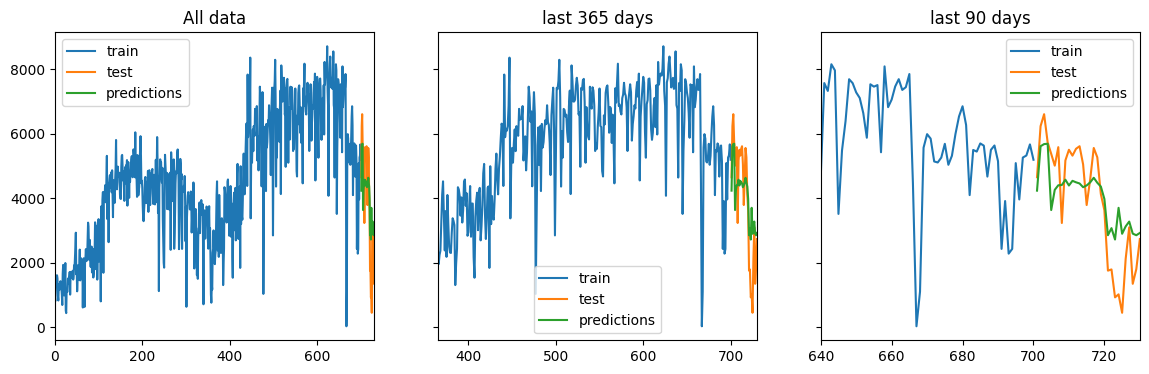

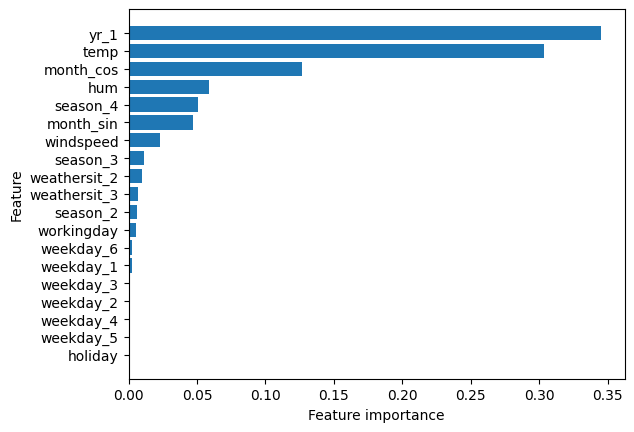

In [21]:
# finally train Random Forest Model with best parameters for best results
print(grit_search.best_params_)
rf_regressor = grit_search.best_estimator_
rf_regressor = rf_regressor.fit(X_train, y_train)

# Predict the model for test data
y_train_pred = rf_regressor.predict(X_train)
y_test_pred = rf_regressor.predict(X_test)
print(f"model score on training data: {rf_regressor.score(X_train, y_train)}")
print(f"model score on testing data: {rf_regressor.score(X_test, y_test)}")

print("Evaluate model on training data:")
evaluate_model(y_train, y_train_pred)
print("Evaluate model on training data:")
evaluate_model(y_test, y_test_pred)

plot_predictions_vs_true_values(y_train, y_test, y_test_pred)

print("Feature importances based on train-data:")
plot_feature_importances(rf_regressor, X_train.columns)

Shap-Feature Importances: here base on our train data, which is the whole dataset without the last 30 days


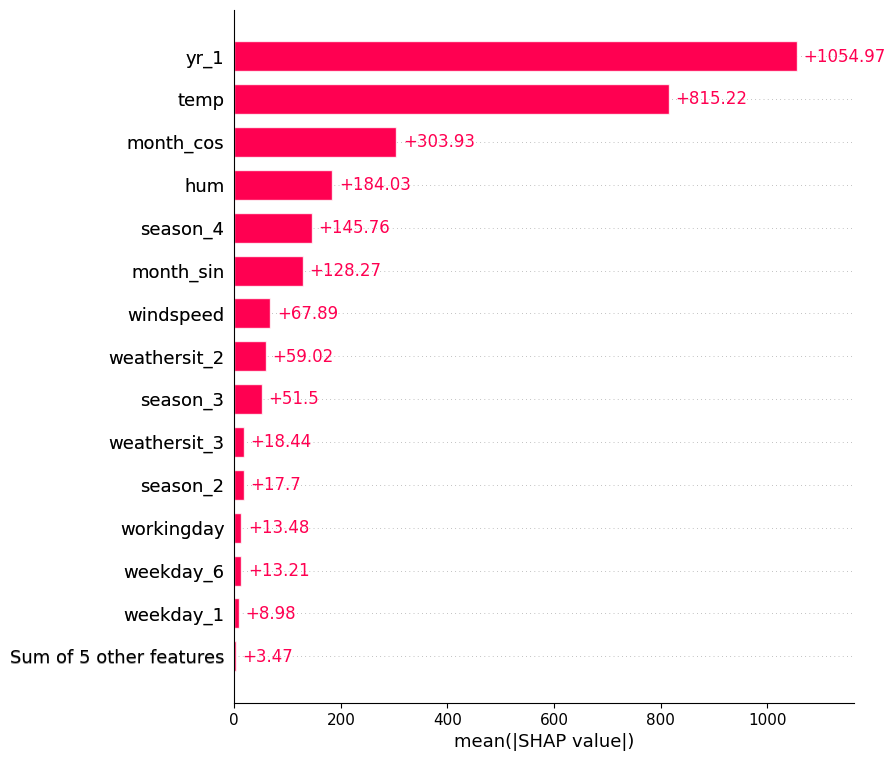

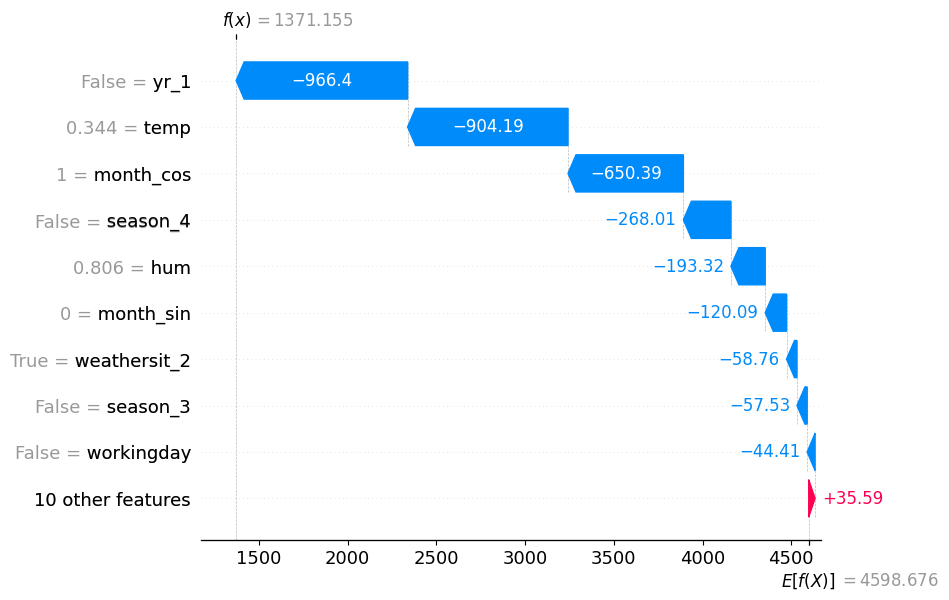

Shap-Feature Importances: here based on our test-data in december 2012 (last 30 days)


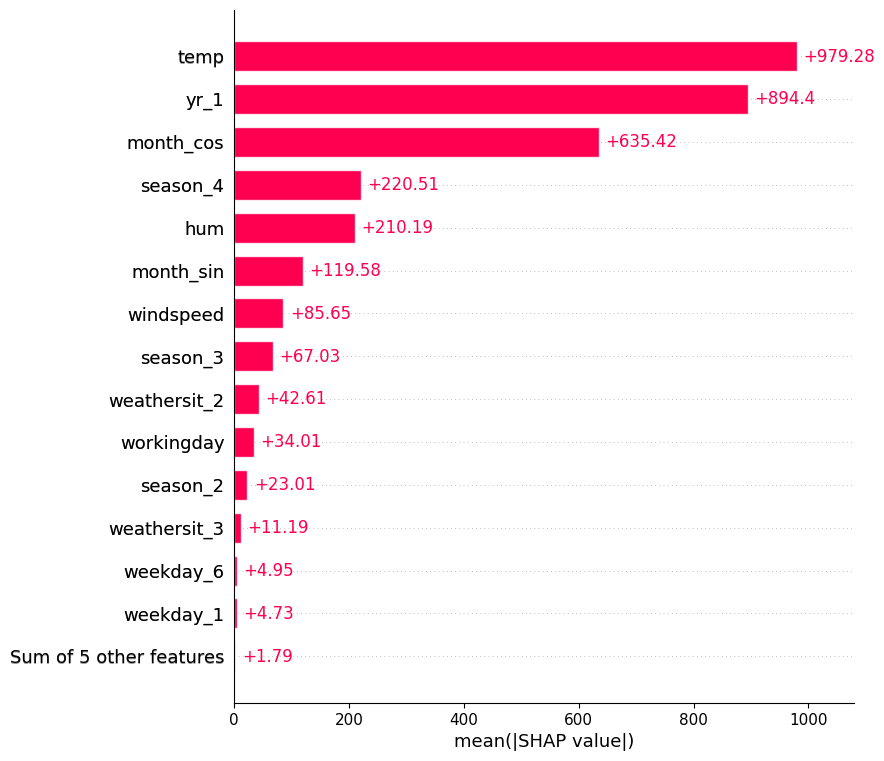

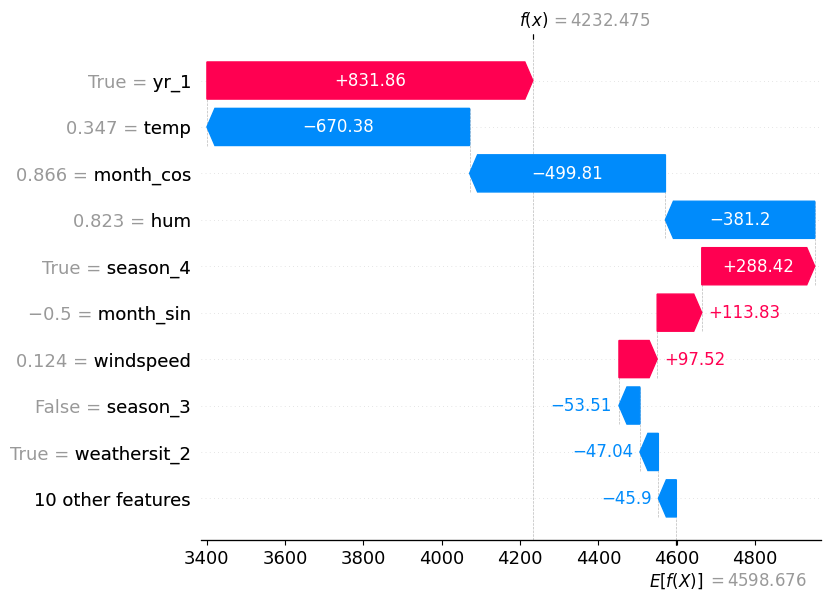

In [22]:
print(
    "Shap-Feature Importances: here base on our train data, which is the whole dataset without the last 30 days"
)
plot_feature_importances_shap(model=rf_regressor, X=X_train)

print(
    "Shap-Feature Importances: here based on our test-data in december 2012 (last 30 days)"
)
plot_feature_importances_shap(model=rf_regressor, X=X_test, max_display=15)

**comments**
                      
The hyperparameter tuning gives us the best parameter for that model:
* we reduced the error rate from +/-9.2 % to +/-8.1? % by day for train-data (and from 24.8% to 24.1% for test-data)
* the mean absolute error reduced from 417 to 367 by day for train-data (and from 978 to 951 for test-data)
* actual parameter are: {'bootstrap': False, 'criterion': 'absolute_error', 'max_depth': None, 'max_features': 10, 'min_samples_leaf': 0.01, 'n_estimators': 300}
  * it make sense, that the criterion of our model is the same as our metric definition
  * it is enough to limit our features by min_samples_leaf = 1% (~6-7 samples by leaf)
* detailed trends can not be predicted correctly, but on average it is fine 
* not all features are relevant --> lets test some feature selections in next section 
* optimizing works on train-data fine / effects on test-data only marginal

the comparison of the shap-values between test and train shows:
* size, signs and ranks of features importants are very different
* seasonal factors does not compensate big Spikes within test data
* december seems not a month, which is easily predictable without lag-variables

**Note:** I also tested and discard:
  * add  `atemp`: discard, because of colinearity and nearly no gain for the goodness of the model
  * use one hot encoding for `month` instead of cyclical feature encoding: discard because of nearly no gain for the goodness of the model

#### 3.2.4 test for further feature selections

Here, I try to clean our model from further unnecessary variables. Therefore I used the recursive feature elimination with cross-validation method [sklearn.feature_selection.RFECV](https://scikit-learn.org/stable/modules/generated/sklearn.feature_selection.RFECV.html#sklearn.feature_selection.RFECV) to select only necessary features 

In [23]:
rf_regressor = grit_search.best_estimator_
feature_selector = RFECV(rf_regressor, step=1, cv=tscv)
feature_selector = feature_selector.fit(X_train, y_train)
print(
    f"Number for finally selected features: {len(X_train.columns[feature_selector.support_].tolist())}\n Names: {X_train.columns[feature_selector.support_].tolist()}\n"
)

# Predict the model for test data
y_test_pred = feature_selector.predict(X_test)
y_train_pred = feature_selector.predict(X_train)
print(f"model score on training data: {feature_selector.score(X_train, y_train)}")
print(f"model score on testing data: {feature_selector.score(X_test, y_test)}")

print("Evaluate model on training data:")
evaluate_model(y_train, y_train_pred)
print("Evaluate model on training data:")
evaluate_model(y_test, y_test_pred)

Number for finally selected features: 19
 Names: ['holiday', 'workingday', 'temp', 'hum', 'windspeed', 'month_cos', 'month_sin', 'season_2', 'season_3', 'season_4', 'yr_1', 'weekday_1', 'weekday_2', 'weekday_3', 'weekday_4', 'weekday_5', 'weekday_6', 'weathersit_2', 'weathersit_3']

model score on training data: 0.9075649782350335
model score on testing data: 0.5951072336063339
Evaluate model on training data:
Mean Absolute Error:   367.25008559201143
Mean Squared Error:    347308.6930582739
Accuracy:              91.89 %. 
avg error rate by day: 8.11 %. 

Evaluate model on training data:
Mean Absolute Error:   951.9529999999997
Mean Squared Error:    1296470.442185
Accuracy:              75.9 %. 
avg error rate by day: 24.1 %. 



**comments**

In this case a further reduction of features are not really necessary. Only 1 features were reduced. 
* does not change much on the result of our model 
* does not change much on the result of our forecast
  
In the end, maybe it would useful to reduce the number features to reduce database by RFE directly to reduce features. 
Effects in my first applications was much bigger, why I decided to leave it and not to update with RFE

#### 3.2.5 final model with reduced features

I retrained here the model with less data, to avoid big data sets for model applications

model score on training data: 0.9075649782350335
model score on testing data: 0.5951072336063339

Evaluate model on training data:
Mean Absolute Error:   367.25008559201143
Mean Squared Error:    347308.6930582739
Accuracy:              91.89 %. 
avg error rate by day: 8.11 %. 

Evaluate model on training data:
Mean Absolute Error:   951.9529999999997
Mean Squared Error:    1296470.442185
Accuracy:              75.9 %. 
avg error rate by day: 24.1 %. 



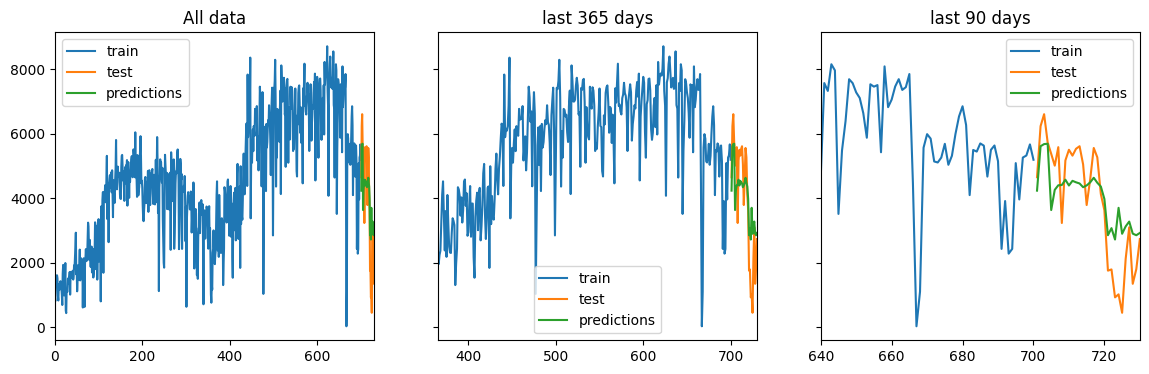

In [24]:
red_cols = X_train.columns[feature_selector.support_].tolist()
X_train[red_cols]
rf_regressor = grit_search.best_estimator_
rf_regressor = rf_regressor.fit(X_train[red_cols], y_train)
print(f"model score on training data: {rf_regressor.score(X_train[red_cols], y_train)}")
print(f"model score on testing data: {rf_regressor.score(X_test[red_cols], y_test)}\n")

# Predict the model for test data
y_train_pred = rf_regressor.predict(X_train[red_cols])
y_test_pred = rf_regressor.predict(X_test[red_cols])

print("Evaluate model on training data:")
evaluate_model(y_train, y_train_pred)
print("Evaluate model on training data:")
evaluate_model(y_test, y_test_pred)

plot_predictions_vs_true_values(y_train, y_test, y_test_pred)

#### 3.3. Save model for future applications

In [25]:
# save model for later use
filename = "finalized_model.pkl"
with open(filename, "wb") as file:
    pickle.dump(rf_regressor, file)
print(f"model saved as {filename}")

model saved as finalized_model.pkl


## Part 4 - Reflection / comments

**Tasks:**
(Optional) Please share with us any free form reflection, comments or feedback you have in the context of this test task.

### Further thoughts
Here I only concentrate mainly to create the best and an adequat model by using the [RandomForestRegressor](https://scikit-learn.org/stable/modules/generated/sklearn.ensemble.RandomForestRegressor.html#sklearn.ensemble.RandomForestRegressor) of scikit-learn. I used the given data to do the following steps of modelling:
* data preparation and transformation of category variables
* define metric and evaluation definitions
* prepare initial model
* adjust model by hyperparameter tuning
* reduce features by RFECV (Recursive feature elimination with cross-validation)
* finalize model with reduced features and optimized parameters

Without changing the model further steps to increase the goodness of fit or adjust the programming style, could be:
*  create difference feature between temperature and feeling temperature 
*  add week-variable and do a cyclical feature encoding
*  add lag-variables to the model. Adequat laged features could by Demand and wethers of the days before.
*  create data preparation with [sklearn.pipeline](https://scikit-learn.org/stable/modules/classes.html#module-sklearn.pipeline), which can be easily applied to new data
  
By analysing that problem, I just found an very [interesting article](https://cienciadedatos.net/documentos/py27-time-series-forecasting-python-scikitlearn.html), which use in addition to *RandomForestRegressor* of scikit-learn the package [Skforecast](https://skforecast.org/0.11.0/index.html). This package seems to be an intuitive library equipped with essential classes and functions to customize any Scikit-learn regression model to effectively address forecasting challenges. There are very interesting aspects within that paper (also other reference paper are of interest) like
* defining number of lag-variables
* combined hyperparameter search of number of lags and sklearn-parmater
* step from "direct multi step forcasting" to a "recursive multi-step forecasting" which is more appropriate for such an application within SIXT
* Backtesting for already trained data 
* and many things more

Now I got no time to dig deeper in that package to integrate it into that notebook.


### Lets look beyond [scikit-learn](https://scikit-learn.org/stable/index.html)
Time serious modelling can be done with many other python packages . Regression methods are:
* statsmodels
* pmdarima
* statsForecast
* skforecast (support also other sklearn methods and XGBoost, LightGBM, Catboost)
* Prophet [Quick Start](https://facebook.github.io/prophet/docs/quick_start.html), which specializes in time series data

Modelling with neuronal networks based mainly on 
* Recurrent Neural Networks RNNs by Keras, Tensorflow, pytorch
* LSTM Recurrent Neural Networks by Keras, Tensorflow, pytorch
  
Interesting article: [Comparative Analysis of Time Series Forecasting: ARIMA vs LSTM for Stock Price Prediction](https://blog.mirkopeters.com/comparative-analysis-of-time-series-forecasting-arima-vs-lstm-for-stock-price-prediction-b661ab61860e)


## Submission

Please submit this notebook with your developments in .ipynb and .html formats as well as your requirements.txt file.

## References

[1] Lichman, M. (2013). UCI Machine Learning Repository [http://archive.ics.uci.edu/ml]. Irvine, CA: University of California, School of Information and Computer Science.